## FD a2 ANN Fitting

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Mounted at /content/drive


In [2]:
target = 'a2'

In [3]:
import pandas as pd
import glob
import os
import numpy as np
import sys
import pickle
from tqdm import tqdm
! pip install pmcx
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 104.5 MB/s eta 0:00:00


### Read the saved CSV

In [4]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
csv_path = '/content/drive/MyDrive/MCX_data/stage2_train.csv'
final_array = np.loadtxt(csv_path, delimiter=',')
print(final_array.shape)
X_train = final_array
#
csv_path_test = '/content/drive/MyDrive/MCX_data/stage2_test.csv'
final_array = np.loadtxt(csv_path_test, delimiter=',')
print(final_array.shape)
X_test = final_array

(10000, 192)
(1000, 192)


### GT

In [6]:
GT_folder_train = '/content/drive/MyDrive/MCX_data/stage2_csv/'
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'

In [7]:
csv_files_train = glob.glob(os.path.join(GT_folder_train, '*.csv'))
GT_all_train = pd.concat([pd.read_csv(f) for f in csv_files_train], ignore_index=True)
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)

In [8]:
sorted_ids = [i+1 for i in range(10000)]
GT_all_train['ID'] = GT_all_train['ID'].astype(int)

GT_filtered = GT_all_train[GT_all_train['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

Y = GT_filtered[target].values
y_train = Y.reshape(-1, 1)

In [9]:
sorted_ids = [i+1 for i in range(1000)]
GT_all_test['ID'] = GT_all_test['ID'].astype(int)
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)

In [10]:
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train = scaler_X.transform(X_train)
X_test  = scaler_X.transform(X_test)
Y_train = scaler_y.transform(y_train)
Y_test = scaler_y.transform(y_test)

In [11]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(10000, 192) (1000, 192) (10000, 1) (1000, 1)


### ANN

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import joblib, tensorflow as tf
WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")

model = Sequential([
    Input(shape=(192,)),
    Dense(1000, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(8192*2, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),
    Dropout(0.0),

    Dense(1)  
])


checkpoint_cb = ModelCheckpoint(
    f"FD_{target}_ANN.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss="mse")

history = model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

model = tf.keras.models.load_model(f"FD_{target}_ANN.keras")

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 65s 195ms/step - loss: 0.9511 - val_loss: 0.7731
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.7548 - val_loss: 0.6837
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.6684 - val_loss: 0.6091
Epoch 4/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.6100 - val_loss: 0.6445
Epoch 5/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - loss: 0.5649 - val_loss: 0.4515
Epoch 6/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 0.5211 - val_loss: 0.4405
Epoch 7/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 0.4473 - val_loss: 0.3989
Epoch 8/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.4159 - val_loss: 0.3510
Epoch 9/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - loss: 0.3885 - val_loss: 0.3440
Epoch 10/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3580 - val_loss: 0.4303
Epoch 11/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3563 - val_loss: 0.3761
Epoch 12/200
282/282 

In [13]:
from pathlib import Path
import joblib, tensorflow as tf

WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

model_path = WEIGHT_DIR / f"FD_{target}_ANN.keras"
model.save(model_path)

joblib.dump(scaler_X, WEIGHT_DIR / f"X_FD_{target}_ANN.pkl")
joblib.dump(scaler_y, WEIGHT_DIR / f"Y_FD_{target}_ANN.pkl")

print("model file exists:", model_path.exists(),
      "size =", model_path.stat().st_size/1e6, "MB")

model file exists: True size = 4413.937482 MB


In [20]:

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[1.1]]))[0][0], scaler_y.transform(np.array([[4.2]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 0.0916


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │       193,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     4,100,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │    33,562,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16384)          │   134,234,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8192)           │   134,225,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,08

 Total params: 1,103,457,341 (4.11 GB)

 Trainable params: 367,819,113 (1.37 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 735,638,228 (2.74 GB)

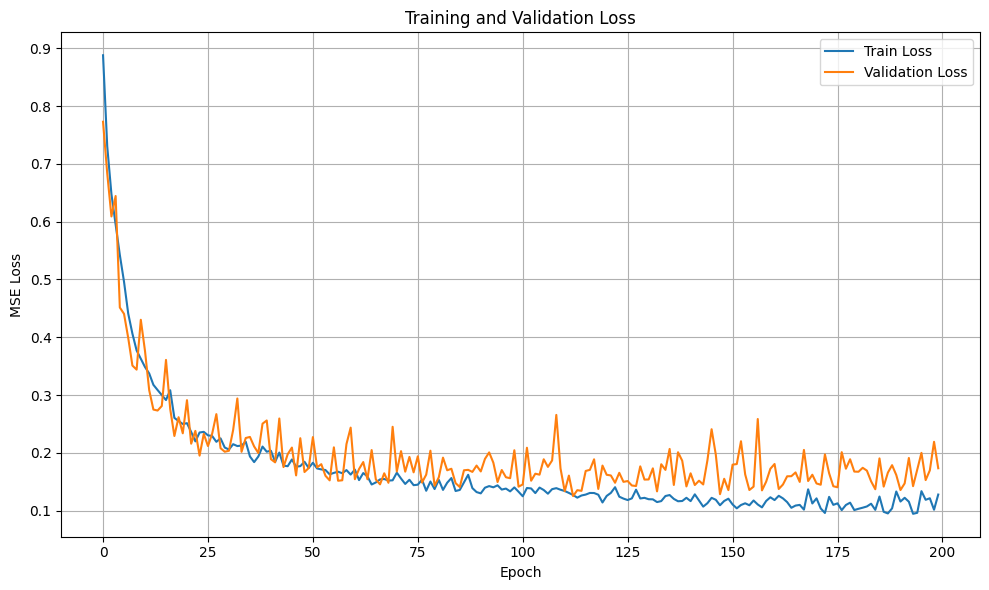

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test MSE: 0.0734


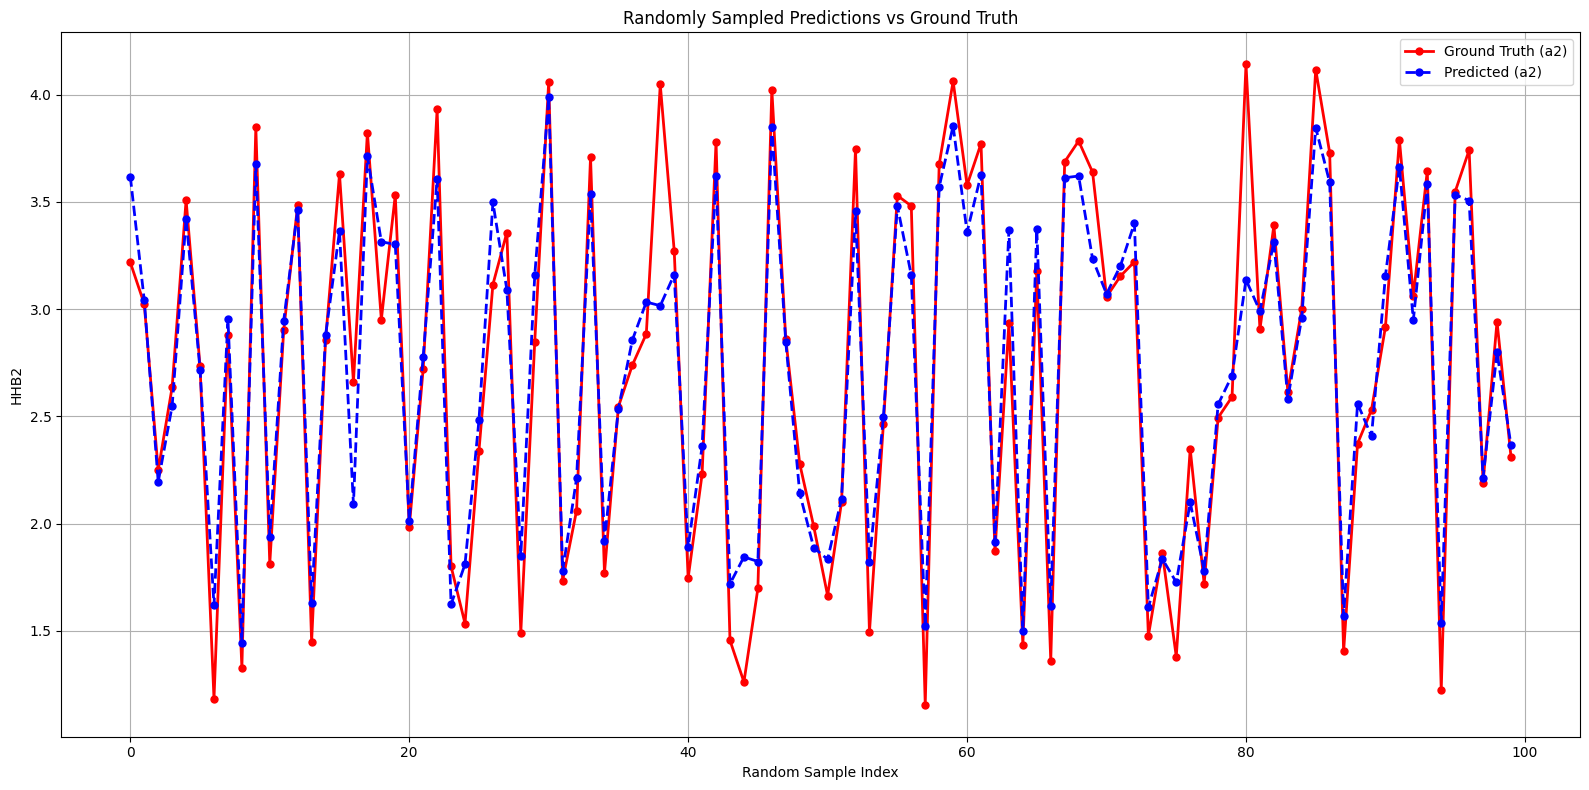

In [23]:
indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE: {mse:.4f}")


# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label=f'Ground Truth ({target})', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label=f'Predicted ({target})', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = np.asarray(y_pred_rescaled).ravel()
y_true = np.asarray(y_test_rescaled).ravel()

residuals = y_pred - y_true
mae = mean_absolute_error(y_true, y_pred)
mare = np.mean(np.abs(residuals) / np.abs(y_true)) * 100
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
bias = np.mean(residuals)
sd   = np.std(residuals, ddof=1)  

print(f"MAE (μm):          {mae:.4f}")
print(f"MARE (%):          {mare:.4f}")
print(f"RMSE (μm):         {rmse:.4f}")
print(f"R²:                {r2:.4f}")
print(f"Bias ± SD (μm):    {bias:.4f} ± {sd:.4f}")


MAE (μm):          0.2055
MARE (%):          8.9223
RMSE (μm):         0.2709
R²:                0.9084
Bias ± SD (μm):    0.0145 ± 0.2706


Test MSE (original scale): 0.0734


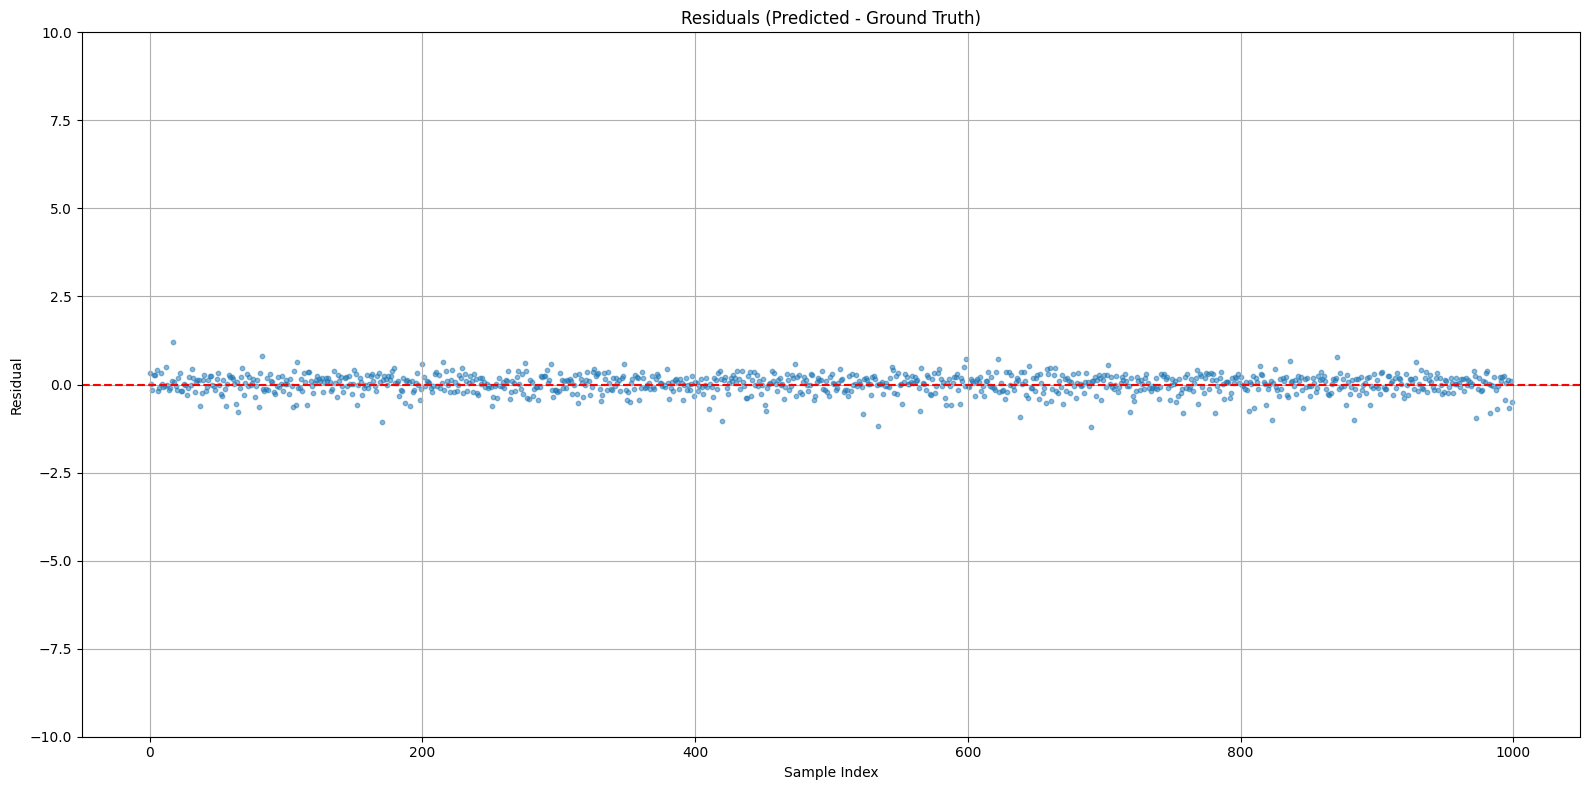

In [26]:

residuals = y_pred_rescaled - y_test_rescaled

mse_rescaled = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

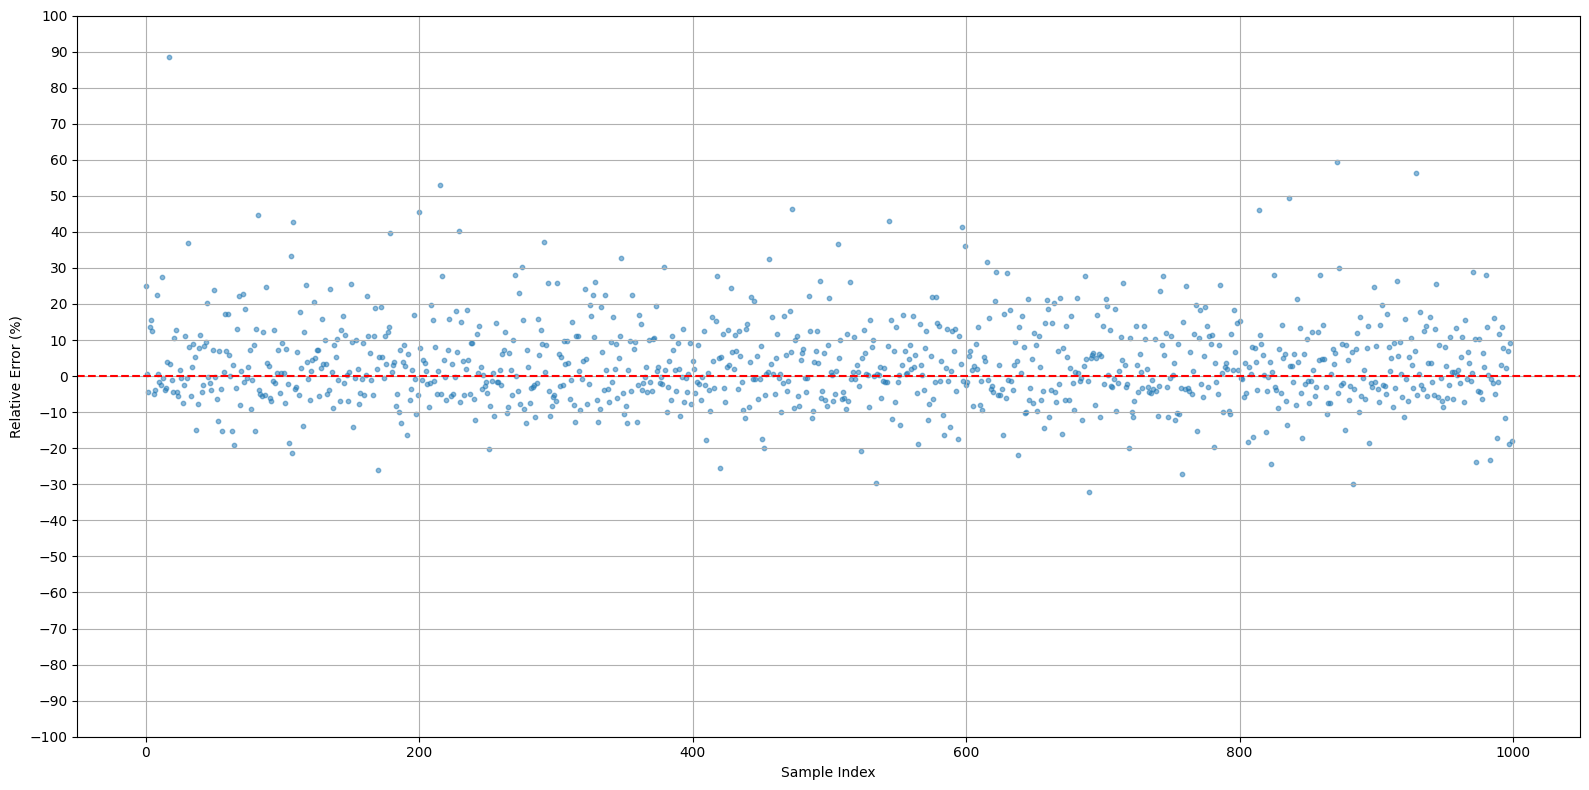

In [28]:
relative_error = ((y_pred_rescaled - y_test_rescaled) / y_test_rescaled) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)
plt.yticks(np.arange(-100, 101, 10))
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


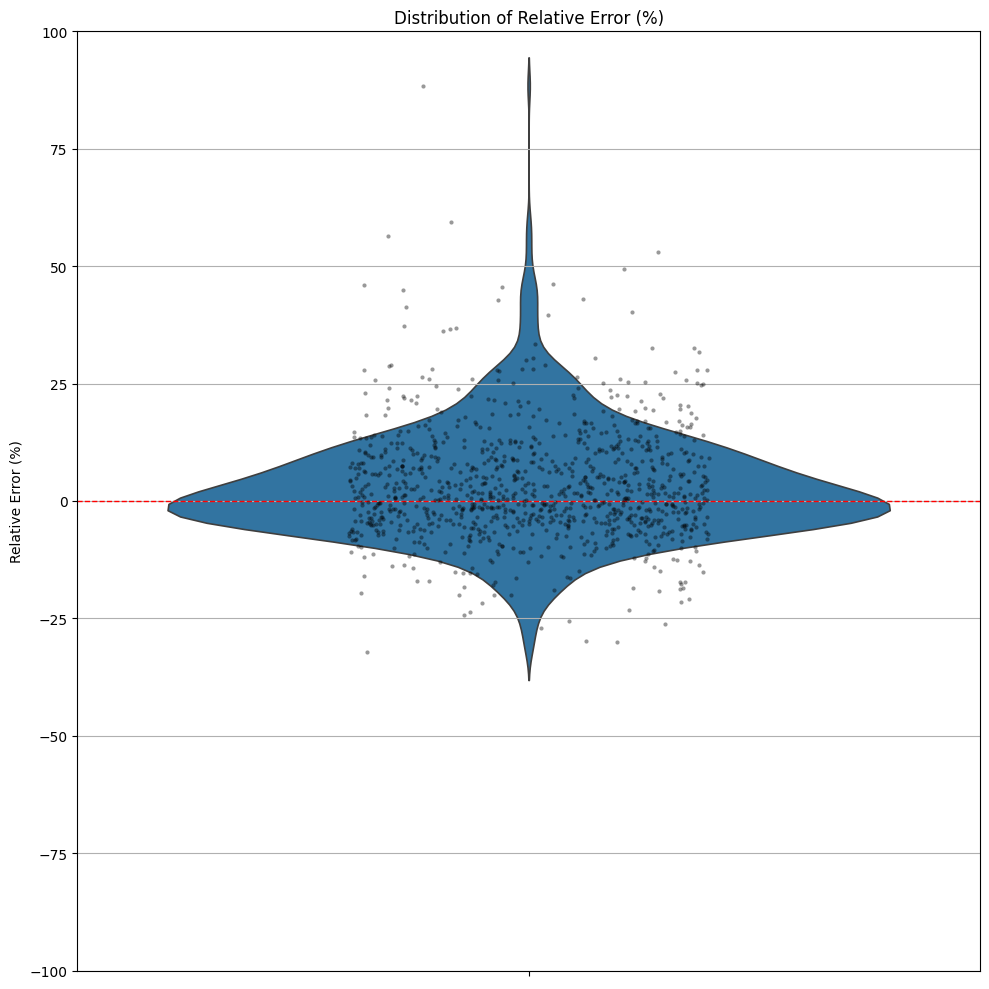

In [29]:
import seaborn as sns
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


R² = 0.9084016481915747
MAPE = 8.922266477202502 %


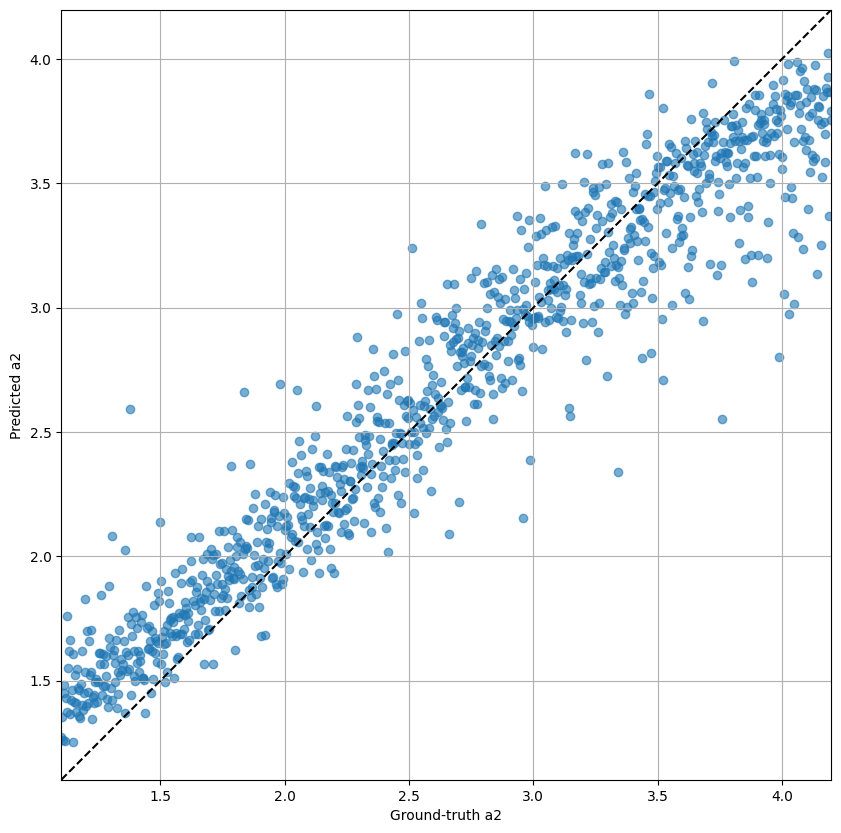

In [30]:

from sklearn.metrics import r2_score, mean_absolute_percentage_error

plt.figure(figsize=(10,10))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
lims = [min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())]
plt.plot(lims, lims, 'k--')              # identity line
plt.xlabel(f'Ground-truth {target}'); plt.ylabel(f'Predicted {target}')
plt.axis('square'); plt.xlim(lims); plt.ylim(lims)
plt.grid()
print("R² =", r2_score(y_test_rescaled, y_pred_rescaled))
print("MAPE =", mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100, "%")
plt.show()

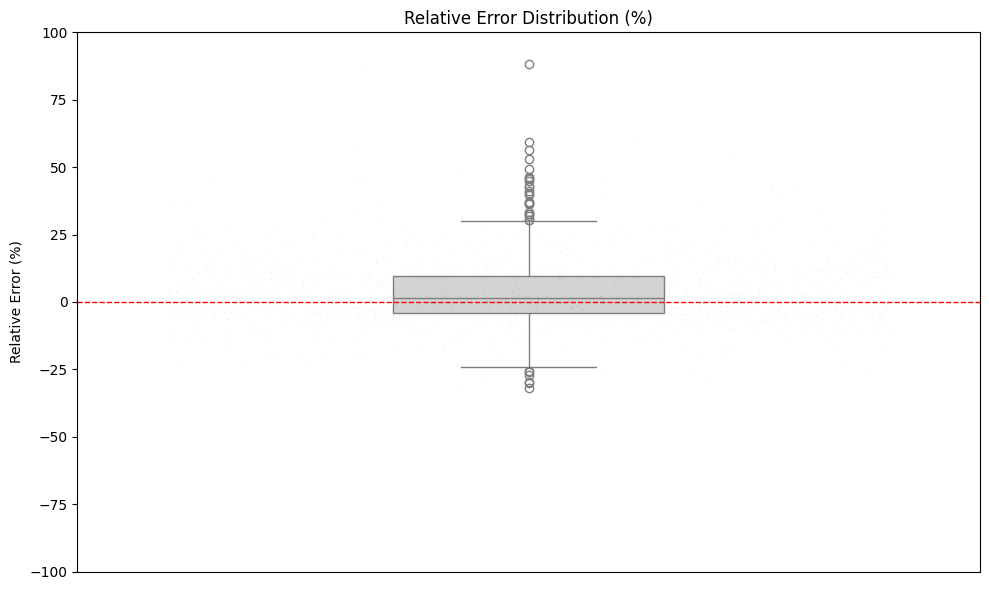

In [31]:
relative_error = relative_error.squeeze()

plt.figure(figsize=(10, 6))
sns.boxplot(y=relative_error, color='lightgray', width=0.3)
sns.stripplot(y=relative_error, color='black', alpha=0.03, jitter=0.4, size=1.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Relative Error Distribution (%)')
plt.ylabel('Relative Error (%)')
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


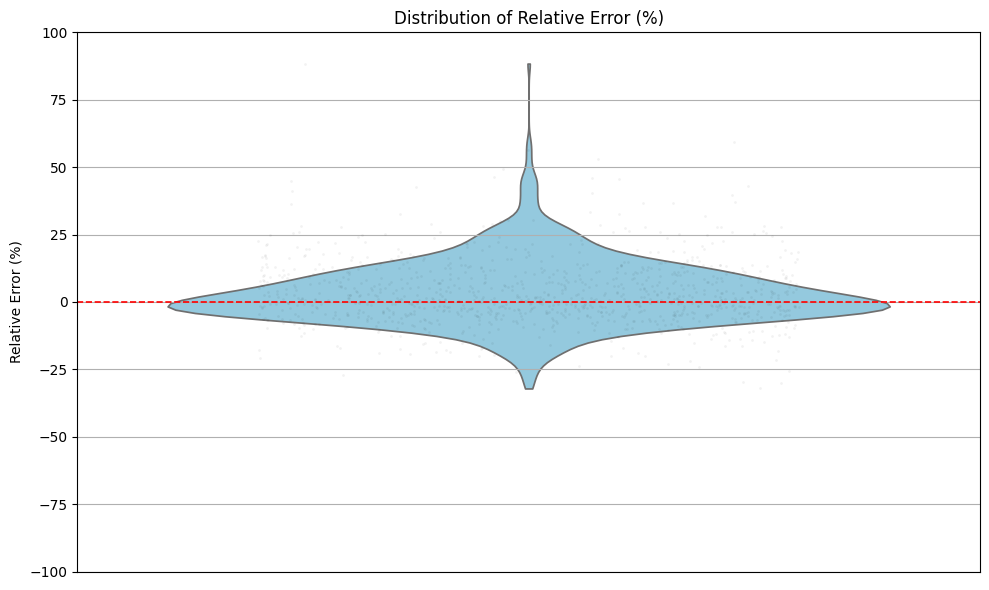

In [32]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)
plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


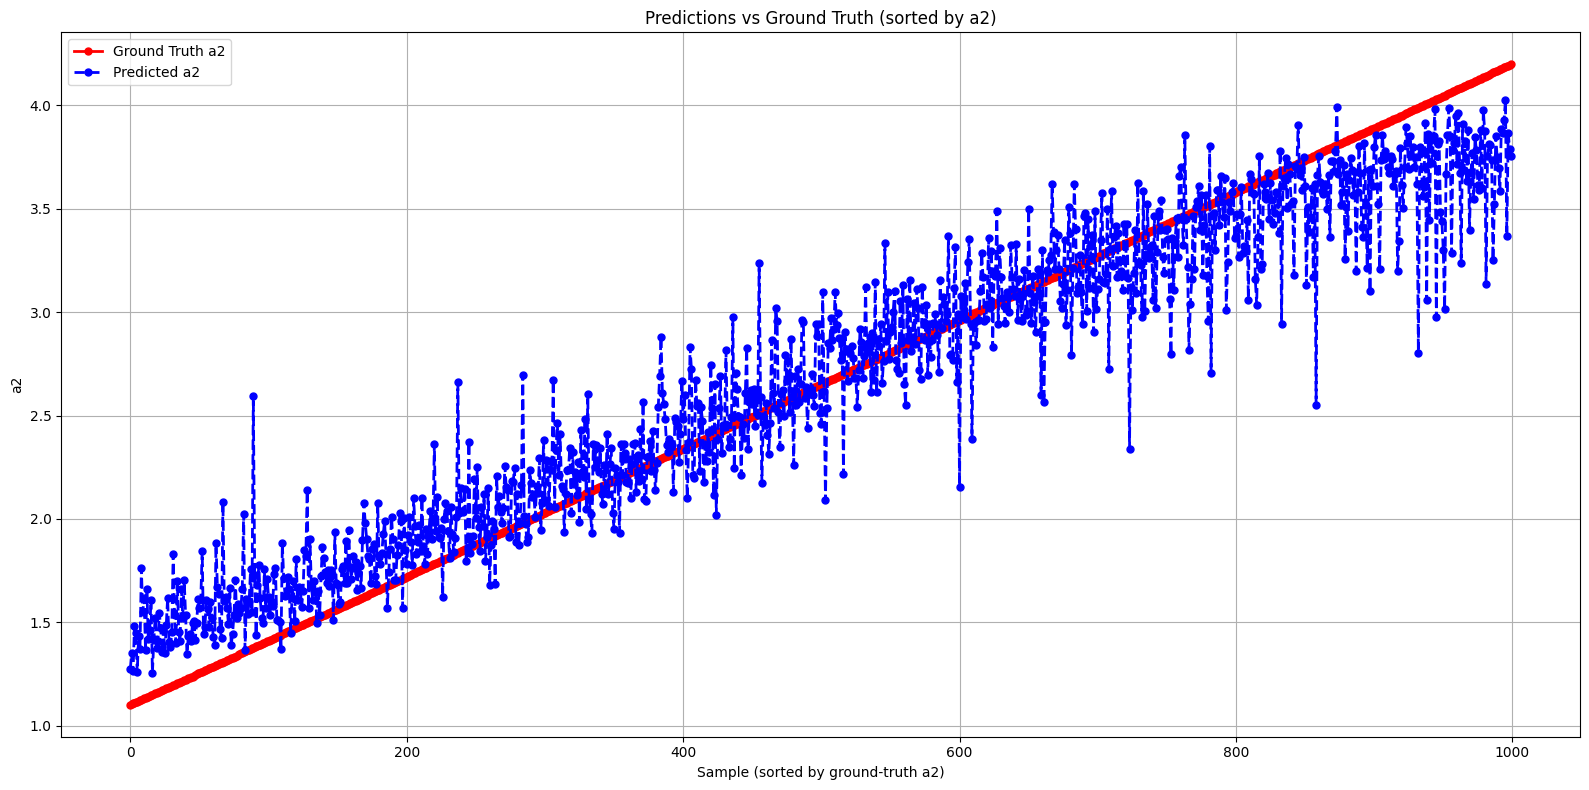

In [33]:
from sklearn.metrics import mean_squared_error

sorted_idx       = np.argsort(y_test_rescaled)      
y_test_sorted    = y_test_rescaled[sorted_idx]
y_pred_sorted    = y_pred_rescaled[sorted_idx]
plt.figure(figsize=(16, 8))
plt.plot(y_test_sorted, 'r-o',  label=f'Ground Truth {target}', linewidth=2, markersize=5)
plt.plot(y_pred_sorted, 'b--o', label=f'Predicted {target}',   linewidth=2, markersize=5)
plt.xlabel(f'Sample (sorted by ground-truth {target})')
plt.ylabel(f'{target}')
plt.title(f'Predictions vs Ground Truth (sorted by {target})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

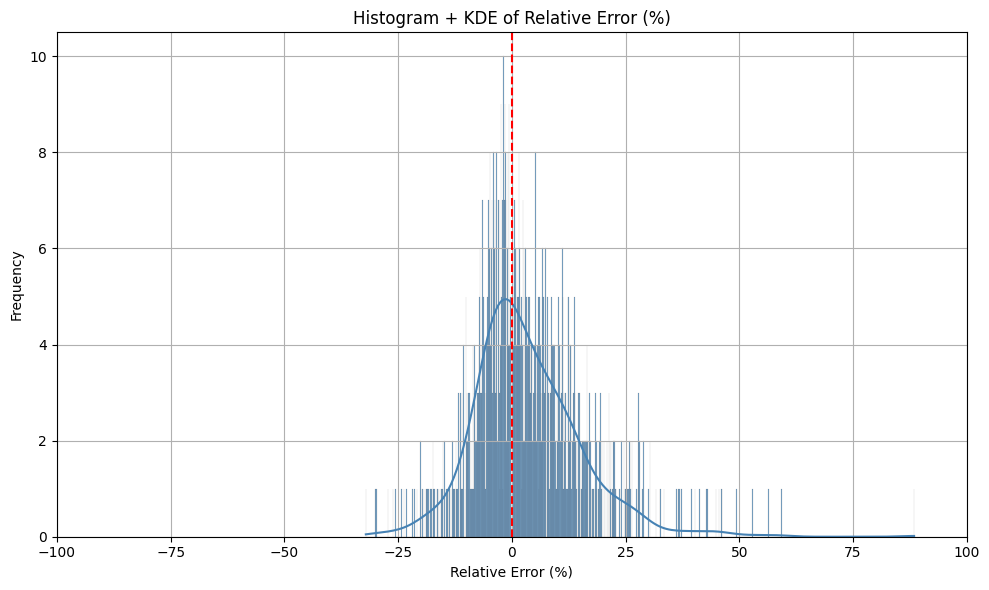

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(relative_error, kde=True, bins=1000, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram + KDE of Relative Error (%)")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid()
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()

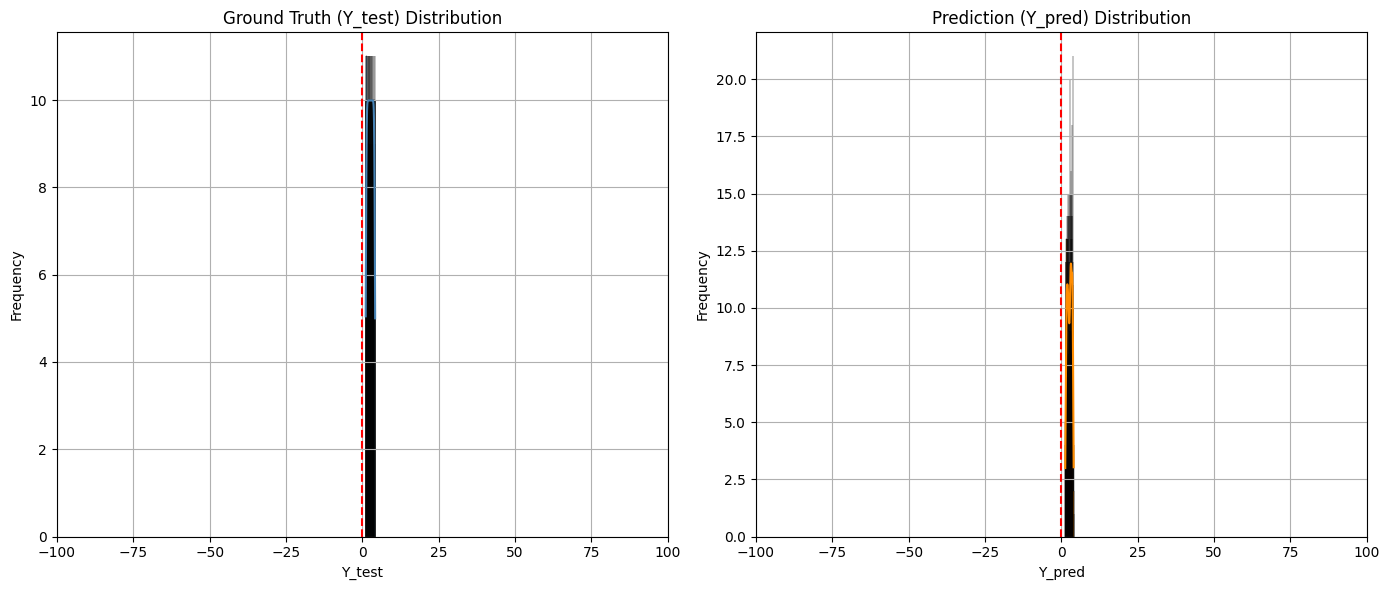

In [35]:
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.histplot(np.asarray(y_test_rescaled).ravel(), kde=True, bins=100, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ground Truth (Y_test) Distribution")
plt.xlabel("Y_test")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.subplot(1, 2, 2)
sns.histplot( np.asarray(y_pred_rescaled).ravel(), kde=True, bins=100, color='darkorange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction (Y_pred) Distribution")
plt.xlabel("Y_pred")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.tight_layout()
plt.show()

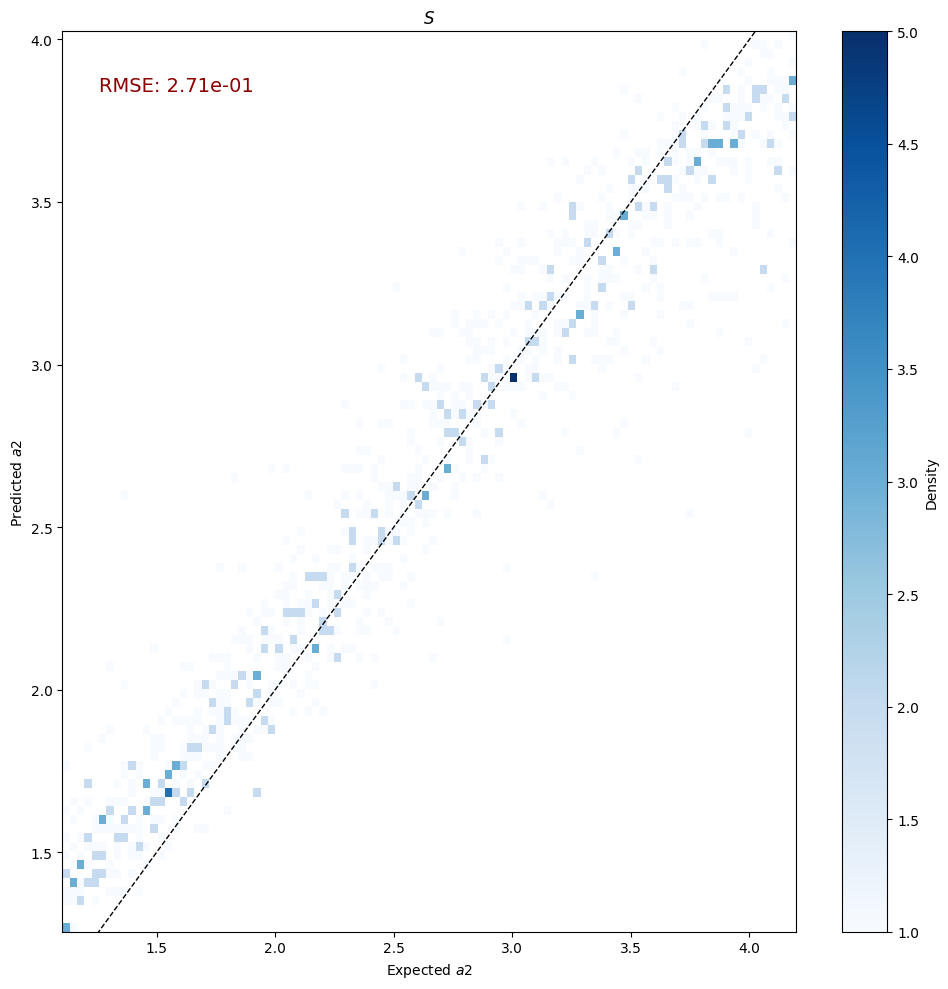

In [36]:
from sklearn.metrics import mean_squared_error


y_true = np.asarray(y_test_rescaled).ravel()
y_pred =np.asarray(y_pred_rescaled).ravel()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))


plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)


plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)


plt.xlabel(f'Expected ${target}$')
plt.ylabel(f'Predicted ${target}$')
plt.title(r'$S$')


plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [37]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 8.9223%


In [38]:
lower, upper = np.percentile(relative_error, [16, 84])
print(f"68% CI of HHb₂ % error: {lower:.2f}% to {upper:.2f}%")

68% CI of HHb₂ % error: -6.53% to 13.62%
